In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter

# Load the data
df = pd.read_csv('swami_vivekananda_letters_complete.csv')

# Clean data (remove editorial notes)
df_clean = df[df['Name'].notna() & (df['Name'] != 'EDITORIAL NOTE')].copy()

# Check what columns we actually have
print("Available columns:")
print(df_clean.columns.tolist())
print("\n" + "="*80)
print("PHASE 1 UNEXPLORED DIRECTIONS - BRIEF ANALYSIS")
print("="*80)

# Parse dates first
df_clean['Date_parsed'] = pd.to_datetime(df_clean['Date'], errors='coerce')
df_clean['Year'] = df_clean['Date_parsed'].dt.year
df_sorted = df_clean.sort_values('Date_parsed')

# 1. RESPONSE TIME PATTERNS
print("\n1. RESPONSE TIME PATTERNS")
print("-" * 40)
# Calculate gaps for top 5 recipients
top5 = ['Sarah Bull', 'Christine Sister', 'Mrs. G.W. Hale', 'Sister Nivedita', 'Mary Hale']
for recipient in top5:
    recipient_letters = df_sorted[df_sorted['Name'] == recipient]['Date_parsed'].dropna()
    if len(recipient_letters) > 1:
        gaps = recipient_letters.diff().dt.days.dropna()
        print(f"{recipient}: {len(recipient_letters)} letters, avg gap {gaps.mean():.1f} days, "
              f"median {gaps.median():.1f} days, max gap {gaps.max():.0f} days")

# 2. AUDIENCE TYPE ANALYSIS
print("\n2. AUDIENCE TYPE ANALYSIS")
print("-" * 40)
print(f"Audience column unique values: {df_clean['Audience'].nunique()}")
print(f"Top audience types:\n{df_clean['Audience'].value_counts().head(10)}")
audience_stats = df_clean.groupby('Audience').agg({
    'body_word_count': ['mean', 'median', 'count'],
    'ps_text': lambda x: (x.notna() & (x != '')).sum()
}).round(1)
audience_stats.columns = ['avg_words', 'median_words', 'count', 'ps_count']
audience_stats['ps_rate'] = (audience_stats['ps_count'] / audience_stats['count'] * 100).round(1)
print(f"\nAudience statistics (top 10 by count):")
print(audience_stats.sort_values('count', ascending=False).head(10))

# 3. TYPE COLUMN ANALYSIS
print("\n3. TYPE COLUMN ANALYSIS")
print("-" * 40)
print(f"Type column unique values: {df_clean['Type'].nunique()}")
print(f"Type distribution:\n{df_clean['Type'].value_counts()}")
type_stats = df_clean.groupby('Type').agg({
    'body_word_count': ['mean', 'median'],
    'ps_text': lambda x: (x.notna() & (x != '')).sum()
}).round(1)
type_stats.columns = ['avg_words', 'median_words', 'ps_count']
print(f"\nType statistics:")
print(type_stats)

# 4. CROSS-RECIPIENT PATTERNS (Temporal Overlap)
print("\n4. CROSS-RECIPIENT PATTERNS")
print("-" * 40)
# For top 5, find their active years
for recipient in top5:
    recipient_years = df_clean[df_clean['Name'] == recipient]['Year'].dropna()
    if len(recipient_years) > 0:
        year_range = f"{int(recipient_years.min())}-{int(recipient_years.max())}"
        year_counts = recipient_years.value_counts().sort_index()
        active_years = year_counts[year_counts > 2].index.tolist()
        print(f"{recipient}: {year_range}, peak years: {[int(y) for y in active_years]}")

# 5. LANGUAGE SOPHISTICATION (English only)
print("\n5. LANGUAGE SOPHISTICATION (English letters)")
print("-" * 40)
english_letters = df_clean[df_clean['Language'] == 'English'].copy()
english_letters['avg_word_length'] = english_letters['body_text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notna(x) and str(x).strip() else np.nan
)
print(f"Overall avg word length: {english_letters['avg_word_length'].mean():.2f} characters")
# By top recipients
for recipient in top5:
    recipient_letters = english_letters[english_letters['Name'] == recipient]
    avg_wl = recipient_letters['avg_word_length'].mean()
    if not np.isnan(avg_wl):
        print(f"{recipient}: {avg_wl:.2f} chars/word, {len(recipient_letters)} English letters")

# 6. MISSING DATA PATTERNS
print("\n6. MISSING DATA PATTERNS")
print("-" * 40)
print(f"Letters without signature: {(df_clean['signature_text'].isna() | (df_clean['signature_text'] == '')).sum()} / {len(df_clean)}")
print(f"Letters without PS: {(df_clean['ps_text'].isna() | (df_clean['ps_text'] == '')).sum()} / {len(df_clean)}")
print(f"Letters without Place: {df_clean['Place'].isna().sum()} / {len(df_clean)}")
print(f"Letters without Date: {df_clean['Date'].isna().sum()} / {len(df_clean)}")

# Check if missing signature correlates with anything
no_sig = df_clean['signature_text'].isna() | (df_clean['signature_text'] == '')
print(f"\nMissing signature by Language:")
print(pd.crosstab(df_clean['Language'], no_sig, normalize='index').round(3) * 100)

# 7. MICRO-TEMPORAL PATTERNS
print("\n7. MICRO-TEMPORAL PATTERNS")
print("-" * 40)
df_clean['Month'] = df_clean['Date_parsed'].dt.month
month_counts = df_clean['Month'].value_counts().sort_index()
print("Letters by month (if date available):")
for month in range(1, 13):
    count = month_counts.get(month, 0)
    print(f"Month {month:2d}: {count:3d} letters")

# Letters per month over time
df_clean['Year_Month'] = df_clean['Date_parsed'].dt.to_period('M')
monthly = df_clean['Year_Month'].value_counts().sort_index()
print(f"\nMonthly writing intensity: max {monthly.max()} letters/month, "
      f"avg {monthly.mean():.1f} letters/month")
print(f"Top 5 most intense months:")
print(monthly.head())

# 8. RECIPIENT OVERLAP ANALYSIS
print("\n8. RECIPIENT OVERLAP ANALYSIS")
print("-" * 40)
# Family/relationship clusters
hale_family = ['Mrs. G.W. Hale', 'Mary Hale']
hale_letters = df_clean[df_clean['Name'].isin(hale_family)]
print(f"Hale family cluster: {len(hale_letters)} letters total")
print(f"  Mrs. G.W. Hale: {len(df_clean[df_clean['Name'] == 'Mrs. G.W. Hale'])} letters")
print(f"  Mary Hale: {len(df_clean[df_clean['Name'] == 'Mary Hale'])} letters")

# Geographic overlap - top recipients by location
if 'Place_Country' in df_clean.columns:
    print(f"\nGeographic overlap (USA-based recipients):")
    usa_recipients = df_clean[df_clean['Place_Country'] == 'USA']['Name'].value_counts().head(5)
    print(usa_recipients)
    print(f"\nGeographic overlap (India-based recipients):")
    india_recipients = df_clean[df_clean['Place_Country'] == 'India']['Name'].value_counts().head(5)
    print(india_recipients)

# American vs Indian circle overlap in time
american_circle = ['Sarah Bull', 'Christine Sister', 'Mrs. G.W. Hale', 'Mary Hale']
indian_circle = ['Pramadadas Mitra', 'Swami Brahmananda', 'Alasinga Perumal']
american_years = df_clean[df_clean['Name'].isin(american_circle)]['Year'].dropna()
indian_years = df_clean[df_clean['Name'].isin(indian_circle)]['Year'].dropna()
if len(american_years) > 0 and len(indian_years) > 0:
    print(f"\nAmerican circle active years: {int(american_years.min())}-{int(american_years.max())}")
    print(f"Indian circle active years: {int(indian_years.min())}-{int(indian_years.max())}")
    overlap_years = set(american_years) & set(indian_years)
    print(f"Years with letters to both circles: {sorted([int(y) for y in overlap_years])}")

print("\n" + "="*80)
print("END OF BRIEF ANALYSIS")
print("="*80)

Available columns:
['Index', 'volume', 'Name', 'Category', 'Type', 'Date', 'Place', 'Source', 'Audience', 'Language', 'section', 'genre', 'href', 'full_url', 'filename', 'has_html', 'has_date', 'has_place', 'has_audience', 'html_content', 'html_length', 'body_text', 'signature_text', 'ps_text', 'body_word_count', 'signature_word_count', 'ps_word_count']

PHASE 1 UNEXPLORED DIRECTIONS - BRIEF ANALYSIS

1. RESPONSE TIME PATTERNS
----------------------------------------

2. AUDIENCE TYPE ANALYSIS
----------------------------------------
Audience column unique values: 114
Top audience types:
Audience
Bull, Sarah           77
Christine, Sister     66
Hale, G. W. Mrs.      60
Nivedita, Sister      48
Hale, Mary            43
MacLeod, Josephine    41
Perumal, Alasinga     40
Brahmananda, Swami    40
Mitra, Pramadadas     33
Sturdy, E.T.          31
Name: count, dtype: int64

Audience statistics (top 10 by count):
                    avg_words  median_words  count  ps_count  ps_rate
Audience  

In [2]:
print("="*80)
print("CORRESPONDENCE RATE & FREQUENCY PATTERNS")
print("="*80)

# Parse dates if not already done
if 'Date_parsed' not in df_clean.columns:
    df_clean['Date_parsed'] = pd.to_datetime(df_clean['Date'], errors='coerce')
df_sorted = df_clean.sort_values('Date_parsed')

# Analyze top 10 recipients
top_recipients = df_clean['Audience'].value_counts().head(10)
print(f"\nAnalyzing top 10 recipients by letter volume:\n")

for recipient in top_recipients.index:
    print(f"\n{'='*60}")
    print(f"RECIPIENT: {recipient}")
    print('='*60)

    # Get all letters to this recipient with dates
    recipient_letters = df_sorted[df_sorted['Audience'] == recipient]['Date_parsed'].dropna()

    if len(recipient_letters) < 2:
        print(f"Only {len(recipient_letters)} letter(s) with date - cannot analyze patterns")
        continue

    # Calculate gaps between consecutive letters
    gaps = recipient_letters.diff().dt.days.dropna()

    # Basic statistics
    print(f"Total letters: {len(recipient_letters)}")
    print(f"Date range: {recipient_letters.min().strftime('%Y-%m-%d')} to {recipient_letters.max().strftime('%Y-%m-%d')}")
    print(f"Total span: {(recipient_letters.max() - recipient_letters.min()).days} days")

    print(f"\nGap statistics (days between consecutive letters):")
    print(f"  Mean gap: {gaps.mean():.1f} days")
    print(f"  Median gap: {gaps.median():.1f} days")
    print(f"  Shortest gap: {gaps.min():.0f} days")
    print(f"  Longest gap: {gaps.max():.0f} days")
    print(f"  Std deviation: {gaps.std():.1f} days")

    # Frequency categories
    rapid_fire = (gaps <= 7).sum()
    regular = ((gaps > 7) & (gaps <= 30)).sum()
    sparse = ((gaps > 30) & (gaps <= 90)).sum()
    very_sparse = (gaps > 90).sum()

    print(f"\nCorrespondence patterns:")
    print(f"  Rapid-fire (≤7 days): {rapid_fire} instances ({rapid_fire/len(gaps)*100:.1f}%)")
    print(f"  Regular (8-30 days): {regular} instances ({regular/len(gaps)*100:.1f}%)")
    print(f"  Sparse (31-90 days): {sparse} instances ({sparse/len(gaps)*100:.1f}%)")
    print(f"  Very sparse (>90 days): {very_sparse} instances ({very_sparse/len(gaps)*100:.1f}%)")

    # Find clustering periods (3+ letters within 30 days)
    clusters = []
    for i in range(len(recipient_letters) - 2):
        window_start = recipient_letters.iloc[i]
        window_end = window_start + timedelta(days=30)
        letters_in_window = recipient_letters[(recipient_letters >= window_start) &
                                              (recipient_letters <= window_end)]
        if len(letters_in_window) >= 3:
            clusters.append((window_start, len(letters_in_window)))

    if clusters:
        # Remove overlapping clusters, keep most intense
        unique_clusters = []
        for start, count in clusters:
            if not any(abs((start - prev_start).days) < 15 for prev_start, _ in unique_clusters):
                unique_clusters.append((start, count))

        print(f"\nIntense correspondence clusters (3+ letters in 30 days):")
        for start, count in sorted(unique_clusters, key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {start.strftime('%Y-%m')}: {count} letters in 30 days")

    # Find longest silence periods
    if len(gaps) > 0:
        longest_silences = gaps.nlargest(3)
        print(f"\nLongest silence periods:")
        for gap_days in longest_silences:
            for i, gap_val in enumerate(gaps):
                if gap_val == gap_days:
                    prev_date = recipient_letters.iloc[i]
                    next_date = recipient_letters.iloc[i+1]
                    print(f"  {gap_days:.0f} days: {prev_date.strftime('%Y-%m-%d')} to {next_date.strftime('%Y-%m-%d')}")
                    break

print("\n" + "="*80)
print("END OF CORRESPONDENCE RATE ANALYSIS")
print("="*80)

CORRESPONDENCE RATE & FREQUENCY PATTERNS

Analyzing top 10 recipients by letter volume:


RECIPIENT: Bull, Sarah
Total letters: 73
Date range: 1894-09-19 to 1902-06-14
Total span: 2824 days

Gap statistics (days between consecutive letters):
  Mean gap: 39.2 days
  Median gap: 21.0 days
  Shortest gap: 0 days
  Longest gap: 318 days
  Std deviation: 60.7 days

Correspondence patterns:
  Rapid-fire (≤7 days): 21 instances (29.2%)
  Regular (8-30 days): 26 instances (36.1%)
  Sparse (31-90 days): 19 instances (26.4%)
  Very sparse (>90 days): 6 instances (8.3%)

Intense correspondence clusters (3+ letters in 30 days):
  1899-11: 5 letters in 30 days
  1895-12: 4 letters in 30 days
  1896-07: 4 letters in 30 days
  1900-02: 4 letters in 30 days
  1894-09: 3 letters in 30 days

Longest silence periods:
  318 days: 1901-03-29 to 1902-02-10
  269 days: 1898-04-04 to 1898-12-29
  228 days: 1897-08-19 to 1898-04-04

RECIPIENT: Christine, Sister
Total letters: 65
Date range: 1895-08-09 to 1902-

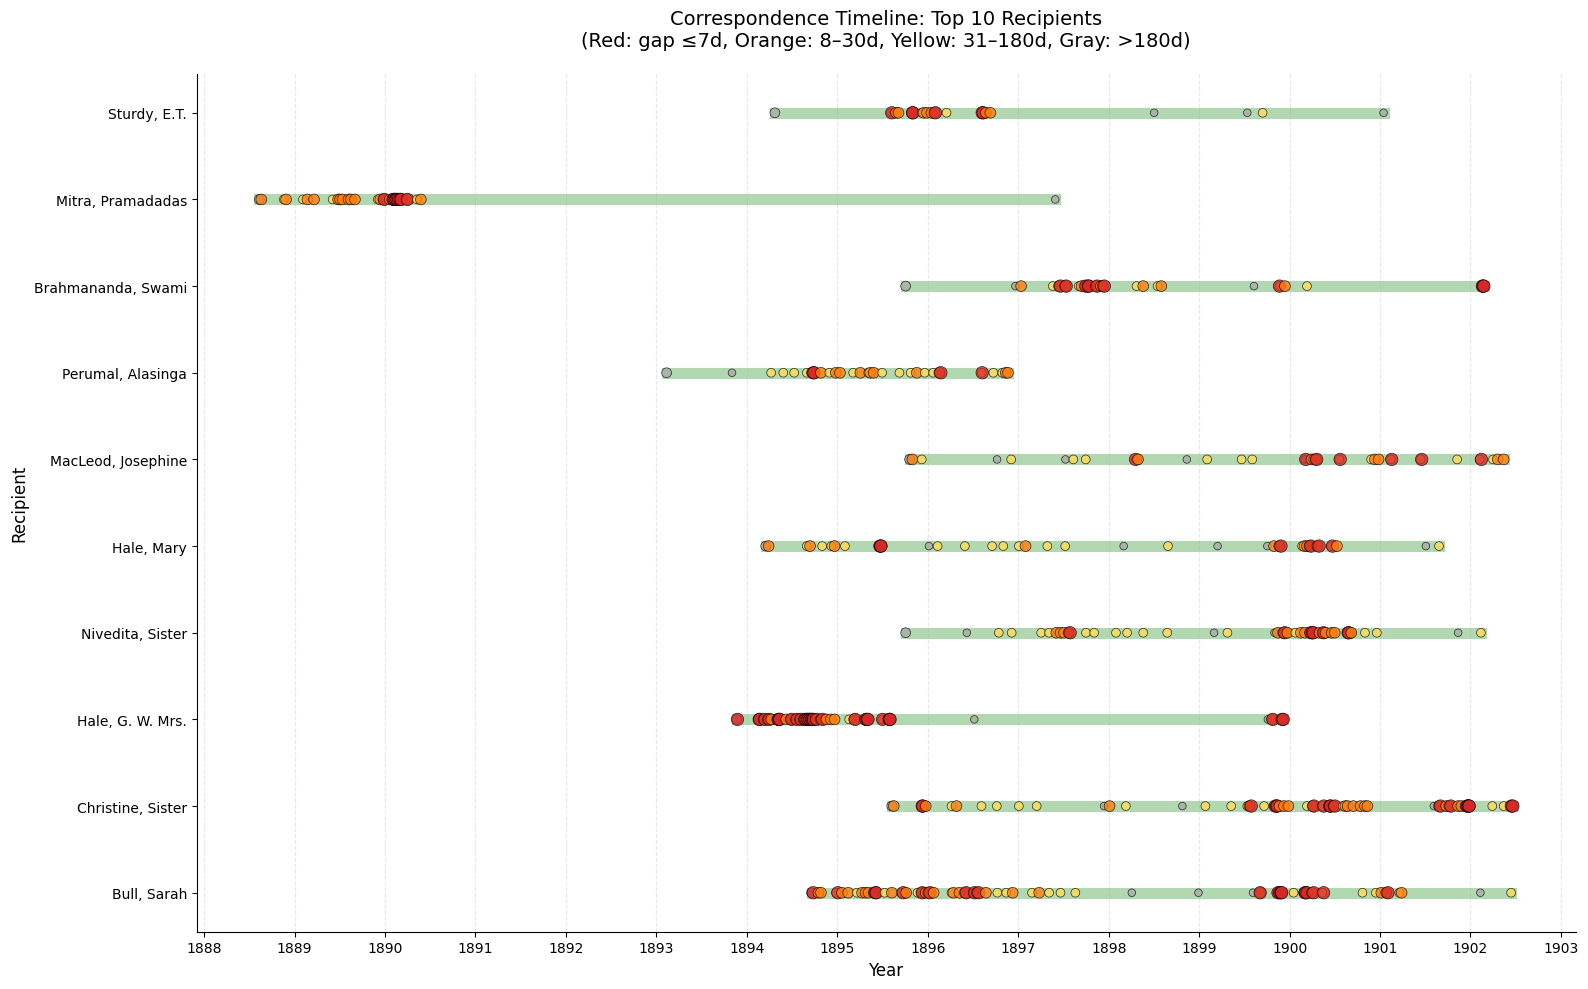

Timeline plot saved


In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Timeline visualization with colored dots and correspondence time bracket
fig, ax = plt.subplots(figsize=(16, 10))

top_recipients = df_clean['Audience'].value_counts().head(10).index
df_sorted = df_clean.sort_values('Date_parsed')

for i, recipient in enumerate(top_recipients):
    recipient_letters = (
        df_sorted[df_sorted['Audience'] == recipient]['Date_parsed']
        .dropna()
        .reset_index(drop=True)
    )

    if len(recipient_letters) > 0:
        # Draw thick green line from first to last letter
        ax.plot(
            [recipient_letters.iloc[0], recipient_letters.iloc[-1]],
            [i, i],
            color='green',
            linewidth=8,
            alpha=0.3,
            zorder=1
        )

        colors = []
        sizes = []

        for j in range(len(recipient_letters)):
            if j == 0:
                # First letter: no previous gap
                colors.append('#aaaaaa')
                sizes.append(50)
                continue

            # FIX: gap BEFORE the letter (this is the key correction)
            gap_days = (recipient_letters.iloc[j] - recipient_letters.iloc[j - 1]).days

            if gap_days <= 7:
                colors.append('#d62728')   # red
                sizes.append(80)
            elif gap_days <= 30:
                colors.append('#ff7f0e')   # orange
                sizes.append(60)
            elif gap_days <= 180:
                colors.append('#ffdd57')   # yellow
                sizes.append(40)
            else:
                colors.append('#aaaaaa')   # gray
                sizes.append(30)

        ax.scatter(
            recipient_letters,
            [i] * len(recipient_letters),
            s=sizes,
            c=colors,
            zorder=3,
            alpha=0.8,
            edgecolors='black',
            linewidths=0.5
        )

# Set y-axis labels
ax.set_yticks(range(len(top_recipients)))
ax.set_yticklabels(top_recipients)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=0)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Recipient', fontsize=12)
ax.set_title(
    'Correspondence Timeline: Top 10 Recipients\n'
    '(Red: gap ≤7d, Orange: 8–30d, Yellow: 31–180d, Gray: >180d)',
    fontsize=14,
    pad=20
)

ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("Timeline plot saved")


In [10]:
import re
import pandas as pd

# Patterns to detect redacted names like A__, M__, S__, X__
patterns = {
    "A__": re.compile(r"\bA__\b"),
    "M__": re.compile(r"\bM__\b"),
    "S__": re.compile(r"\bS__\b"),
    "X__": re.compile(r"\bX__\b"),
}

def extract_sentences_with_redactions(text):
    """Return list of (redaction, sentence) pairs found in text."""
    if pd.isna(text):
        return []

    # Simple sentence split (robust enough for letters)
    sentences = re.split(r'(?<=[.!?])\s+', text)

    matches = []
    for sentence in sentences:
        for key, pattern in patterns.items():
            if pattern.search(sentence):
                matches.append((key, sentence.strip()))
    return matches


results = []

for _, row in df_clean.iterrows():
    matches = extract_sentences_with_redactions(row['body_text'])

    for redaction, sentence in matches:
        results.append({
            "Redaction": redaction,
            "Letter_Name": row.get('Name'),
            "Date": row.get('Date_parsed'),
            "Year": row.get('Date_parsed').year if pd.notna(row.get('Date_parsed')) else None,
            "Recipient": row.get('Audience'),
            "Sentence": sentence
        })

results_df = pd.DataFrame(results)

# Sort for readability
results_df = results_df.sort_values(["Redaction", "Date"])

# Display or print
print(f"Found {len(results_df)} redacted-name occurrences\n")
for _, r in results_df.iterrows():
    print("=" * 80)
    print(f"Redaction : {r['Redaction']}")
    print(f"Letter    : {r['Letter_Name']}")
    print(f"Date      : {r['Date']} ({r['Year']})")
    print(f"Recipient : {r['Recipient']}")
    print(f"Sentence  : {r['Sentence']}")


Found 13 redacted-name occurrences

Redaction : A__
Letter    : XLVI Mother
Date      : 1899-11-30 00:00:00 (1899.0)
Recipient : Leggett, Francis Mrs.
Sentence  : These lines in haste as A__ is waiting.
Redaction : A__
Letter    : CLXXIII Dhira Mata
Date      : 1900-04-08 00:00:00 (1900.0)
Recipient : Bull, Sarah
Sentence  : Ole Bull

DEAR DHIRA MATA,

Here is a long letter from A__.
Redaction : A__
Letter    : CLXXIII Dhira Mata
Date      : 1900-04-08 00:00:00 (1900.0)
Recipient : Bull, Sarah
Sentence  : A__ has done good work so far; and, of course, you know I do not meddle with my workers at all.
Redaction : A__
Letter    : CLXXIII Dhira Mata
Date      : 1900-04-08 00:00:00 (1900.0)
Recipient : Bull, Sarah
Sentence  : Did you reveal to A__ that I have given over to you the charge of the entire work?
Redaction : A__
Letter    : CLXXIV Joe
Date      : 1900-04-10 00:00:00 (1900.0)
Recipient : MacLeod, Josephine
Sentence  : I got a letter from A__ stating that he was going to leave New 

In [29]:
import pandas as pd

print("=" * 80)
print("FULL RECORD DUMP FOR LETTER: LIII Kali")
print("=" * 80)

# Try common column names safely
possible_name_cols = ['Letter', 'Letter_Name', 'letter_name', 'Title', 'Name']

letter_rows = pd.DataFrame()

for col in possible_name_cols:
    if col in df_clean.columns:
        matches = df_clean[df_clean[col].astype(str) == 'LIII Kali']
        if len(matches) > 0:
            letter_rows = matches
            print(f"\nMatched using column: {col}")
            break

# Fallback: search anywhere in the row
if letter_rows.empty:
    print("\nExact column match not found — performing full-row search")
    mask = df_clean.apply(
        lambda row: row.astype(str).str.contains('LIII Kali', regex=False).any(),
        axis=1
    )
    letter_rows = df_clean[mask]

if letter_rows.empty:
    print("\n❌ No rows found for 'LIII Kali'")
else:
    print(f"\nRows found: {len(letter_rows)}")
    print("-" * 80)

    for idx, row in letter_rows.iterrows():
        print(f"\nROW INDEX: {idx}")
        print("-" * 80)
        for col in df_clean.columns:
            val = row[col]
            print(f"{col:25} : {repr(val)}")

print("\nDONE.")


FULL RECORD DUMP FOR LETTER: LIII Kali

Matched using column: Name

Rows found: 1
--------------------------------------------------------------------------------

ROW INDEX: 398
--------------------------------------------------------------------------------
Index                     : 912
volume                    : 8.0
Name                      : 'LIII Kali'
Category                  : 'Epistle'
Type                      : 'Letter'
Date                      : '1895/10/00'
Place                     : 'England, Reading, Caversham'
Source                    : nan
Audience                  : 'Abhedananda, Swami'
Language                  : 'Bengali'
section                   : 'epistles_fourth_series'
genre                     : 'Letters'
href                      : 'volume_8/epistles_fourth_series/053_kali.htm'
full_url                  : 'https://www.ramakrishnavivekananda.info/vivekananda/volume_8/epistles_fourth_series/053_kali.htm'
filename                  : '053_kali.htm'
has_htm

SYNTACTIC ANALYSIS OF EDITORIAL REDACTIONS

1️⃣ REDACTION TOKEN EXTRACTION
--------------------------------------------------------------------------------
Total redaction tokens found: 13
Unique redaction forms: 4

All redaction forms by frequency:
full_token
A__    10
S__     1
X__     1
M__     1
Name: count, dtype: int64

Redaction forms by initial:
initial
A    10
S     1
X     1
M     1
Name: count, dtype: int64

2️⃣ UNDERSCORE LENGTH ANALYSIS
--------------------------------------------------------------------------------

Underscore count statistics:
count    13.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: underscore_count, dtype: float64

Underscore count distribution:
underscore_count
2    13
Name: count, dtype: int64

Underscore count by initial letter:
  A: mean=2.00, std=0.00, min=2, max=2, count=10
  S: mean=2.00, std=nan, min=2, max=2, count=1
  X: mean=2.00, std=nan, min=2, max=2, count=1
  M: mean=2.00, std=n

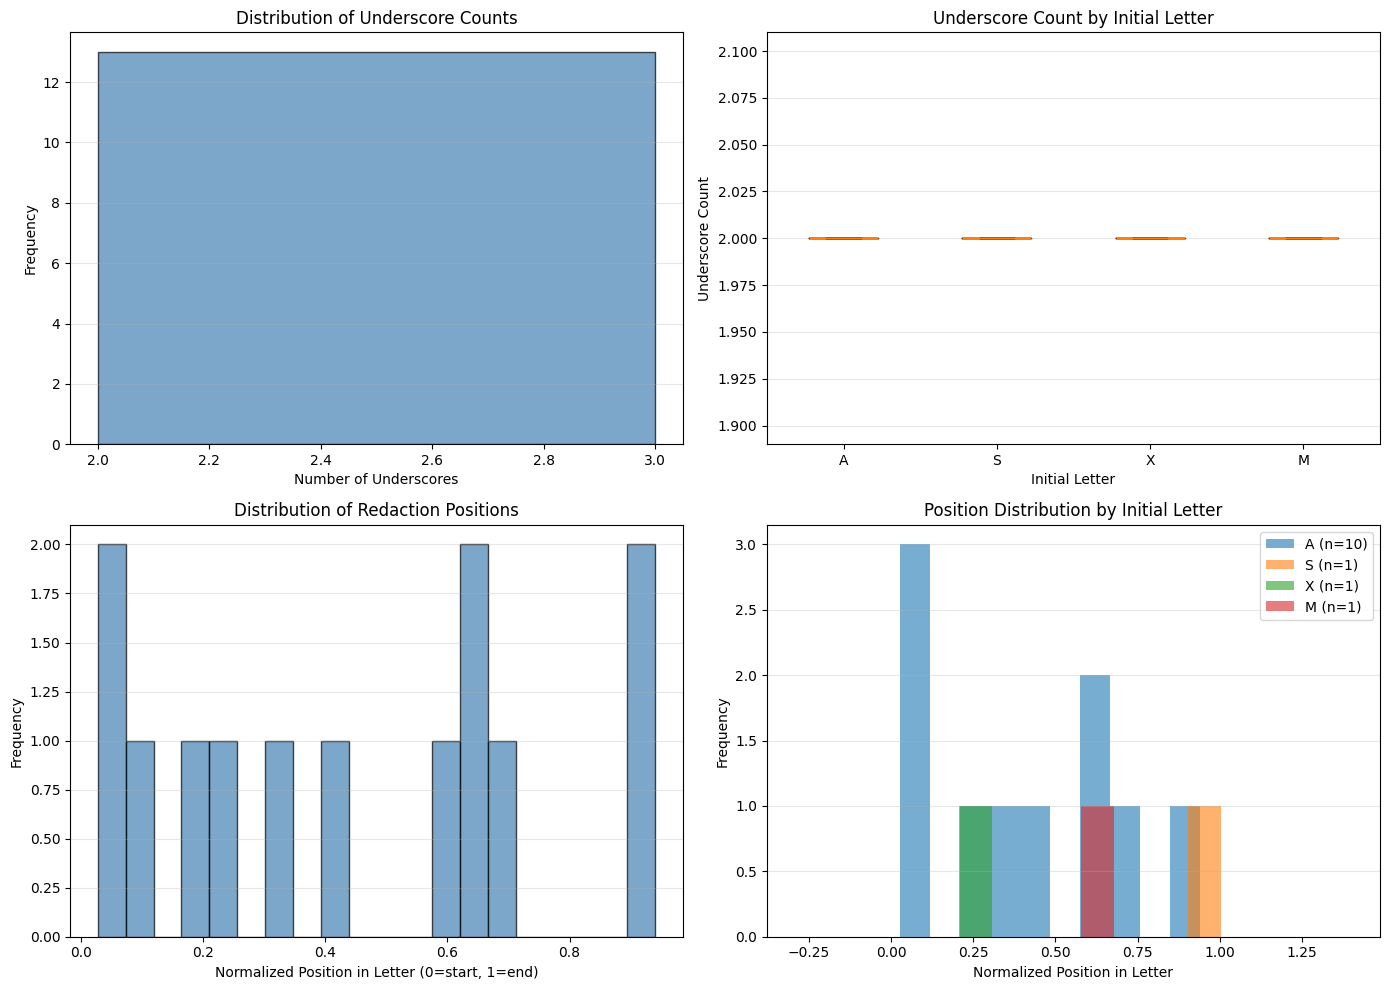


5️⃣ FORMAL CONTEXT ANALYSIS
--------------------------------------------------------------------------------

Left punctuation frequency:
  '': 7
  '.': 5
  '"': 1

Right punctuation frequency:
  '': 6
  '.': 4
  '!': 2
  ',': 1

Left token frequency:
  'from': 2
  'as': 1
  'sorry': 1
  'Mrs': 1
  'vision': 1
  'of': 1
  'off': 1
  'to': 1
  'with': 1
  'that': 1
  'this': 1
  'Now': 1

Right token frequency:
  'is': 2
  'has': 2
  'and': 1
  'Babu': 1
  'He': 1
  'that': 1
  'stating': 1
  'I': 1
  'wanted': 1
  'business': 1
  'disturbs': 1

Contextual patterns:
  In parentheses: 0 (0.0%)
  Near sentence boundary: 3 (23.1%)
  After title: 1 (7.7%)

ANALYSIS COMPLETE


In [12]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

print("="*80)
print("SYNTACTIC ANALYSIS OF EDITORIAL REDACTIONS")
print("="*80)

# ============================================================================
# 1️⃣ REDACTION TOKEN EXTRACTION
# ============================================================================
print("\n1️⃣ REDACTION TOKEN EXTRACTION")
print("-"*80)

# Pattern to match redactions: capital letter(s) followed by underscores
redaction_pattern = r'\b([A-Z](?:\.[A-Z])*)(_{2,})\b'

redaction_data = []

for idx, row in df_clean.iterrows():
    text = str(row['body_text']) if pd.notna(row['body_text']) else ''
    matches = re.finditer(redaction_pattern, text)

    for match in matches:
        full_token = match.group(0)
        initial = match.group(1)
        underscores = match.group(2)
        year_val = row['Year'] if 'Year' in row and pd.notna(row['Year']) else None

        redaction_data.append({
            'letter_idx': idx,
            'full_token': full_token,
            'initial': initial,
            'underscore_count': len(underscores),
            'recipient': row['Audience'],
            'year': year_val,
            'position_in_text': match.start() / len(text) if len(text) > 0 else 0
        })

redaction_df = pd.DataFrame(redaction_data)

if len(redaction_df) == 0:
    print("NO REDACTIONS FOUND IN DATASET")
    print("\nThis suggests either:")
    print("  - No editorial redactions exist in the preserved letters")
    print("  - Redactions use a different encoding system")
    print("  - Text extraction did not preserve redaction markers")
else:
    print(f"Total redaction tokens found: {len(redaction_df)}")
    print(f"Unique redaction forms: {redaction_df['full_token'].nunique()}")
    print(f"\nAll redaction forms by frequency:")
    print(redaction_df['full_token'].value_counts())

    print(f"\nRedaction forms by initial:")
    print(redaction_df['initial'].value_counts())

# ============================================================================
# 2️⃣ UNDERSCORE LENGTH ANALYSIS
# ============================================================================
if len(redaction_df) > 0:
    print("\n2️⃣ UNDERSCORE LENGTH ANALYSIS")
    print("-"*80)

    print(f"\nUnderscore count statistics:")
    print(redaction_df['underscore_count'].describe())

    print(f"\nUnderscore count distribution:")
    print(redaction_df['underscore_count'].value_counts().sort_index())

    print(f"\nUnderscore count by initial letter:")
    for initial in redaction_df['initial'].unique():
        initial_data = redaction_df[redaction_df['initial'] == initial]['underscore_count']
        print(f"  {initial}: mean={initial_data.mean():.2f}, std={initial_data.std():.2f}, "
              f"min={initial_data.min()}, max={initial_data.max()}, count={len(initial_data)}")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Histogram of underscore counts
    underscore_range = range(redaction_df['underscore_count'].min(),
                            redaction_df['underscore_count'].max()+2)
    axes[0, 0].hist(redaction_df['underscore_count'], bins=underscore_range,
                    color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Underscores')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Underscore Counts')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Boxplot by initial letter
    initials = redaction_df['initial'].unique()
    boxplot_data = [redaction_df[redaction_df['initial'] == init]['underscore_count'].values
                    for init in initials]
    axes[0, 1].boxplot(boxplot_data, tick_labels=initials)
    axes[0, 1].set_xlabel('Initial Letter')
    axes[0, 1].set_ylabel('Underscore Count')
    axes[0, 1].set_title('Underscore Count by Initial Letter')
    axes[0, 1].grid(axis='y', alpha=0.3)

    # ============================================================================
    # 3️⃣ CONSISTENCY & REUSE ANALYSIS
    # ============================================================================
    print("\n3️⃣ CONSISTENCY & REUSE ANALYSIS")
    print("-"*80)

    reuse_analysis = redaction_df.groupby('full_token').agg({
        'letter_idx': ['count', lambda x: x.nunique()],
        'year': [lambda x: f"{x.min():.0f}-{x.max():.0f}" if x.notna().any() else 'N/A'],
        'recipient': [lambda x: x.nunique()]
    })
    reuse_analysis.columns = ['frequency', 'num_letters', 'year_span', 'num_recipients']
    reuse_analysis = reuse_analysis.sort_values('frequency', ascending=False).reset_index()

    print("\nAll redaction forms with reuse statistics:")
    print(reuse_analysis.to_string())

    print(f"\nRedaction forms appearing in multiple letters: {(reuse_analysis['num_letters'] > 1).sum()}")
    print(f"Redaction forms appearing with multiple recipients: {(reuse_analysis['num_recipients'] > 1).sum()}")

    # ============================================================================
    # 4️⃣ POSITIONAL SYNTAX ANALYSIS
    # ============================================================================
    print("\n4️⃣ POSITIONAL SYNTAX ANALYSIS")
    print("-"*80)

    print(f"\nPosition statistics (0=start, 1=end):")
    print(redaction_df['position_in_text'].describe())

    # Histogram of positions
    axes[1, 0].hist(redaction_df['position_in_text'], bins=20, color='steelblue',
                    edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Normalized Position in Letter (0=start, 1=end)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Redaction Positions')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Position distribution by initial
    for initial in initials:
        initial_positions = redaction_df[redaction_df['initial'] == initial]['position_in_text']
        if len(initial_positions) > 0:
            axes[1, 1].hist(initial_positions, bins=10, alpha=0.6, label=f"{initial} (n={len(initial_positions)})")
    axes[1, 1].set_xlabel('Normalized Position in Letter')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Position Distribution by Initial Letter')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    # plt.savefig('/mnt/user-data/outputs/redaction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ============================================================================
    # 5️⃣ FORMAL CONTEXT (NON-SEMANTIC)
    # ============================================================================
    print("\n5️⃣ FORMAL CONTEXT ANALYSIS")
    print("-"*80)

    context_data = {
        'left_token': [],
        'right_token': [],
        'left_punct': [],
        'right_punct': [],
        'in_parentheses': [],
        'near_sentence_boundary': [],
        'after_title': []
    }

    titles = ['Mr.', 'Mrs.', 'Miss', 'Dr.', 'Swami', 'Raja', 'Maharaja', 'Sri', 'Shri']

    for idx, row in df_clean.iterrows():
        text = str(row['body_text']) if pd.notna(row['body_text']) else ''
        matches = list(re.finditer(redaction_pattern, text))

        for match in matches:
            start = match.start()
            end = match.end()

            # Get left context (20 chars before)
            left_ctx = text[max(0, start-20):start]
            # Get right context (20 chars after)
            right_ctx = text[end:min(len(text), end+20)]

            # Left/right tokens
            left_words = re.findall(r'\b\w+\b', left_ctx)
            right_words = re.findall(r'\b\w+\b', right_ctx)
            context_data['left_token'].append(left_words[-1] if left_words else '')
            context_data['right_token'].append(right_words[0] if right_words else '')

            # Punctuation
            left_punct = re.findall(r'[.,;:!?\(\)\[\]"\']', left_ctx)
            right_punct = re.findall(r'[.,;:!?\(\)\[\]"\']', right_ctx)
            context_data['left_punct'].append(left_punct[-1] if left_punct else '')
            context_data['right_punct'].append(right_punct[0] if right_punct else '')

            # In parentheses
            context_data['in_parentheses'].append('(' in left_ctx and ')' in right_ctx)

            # Near sentence boundary
            boundary_ctx = text[max(0, start-5):start]
            context_data['near_sentence_boundary'].append(any(p in boundary_ctx for p in ['.', '!', '?']))

            # After title
            context_data['after_title'].append(any(title in left_ctx for title in titles))

    context_df = pd.DataFrame(context_data)

    print(f"\nLeft punctuation frequency:")
    left_punct_counts = Counter(context_df['left_punct'])
    for punct, count in left_punct_counts.most_common(10):
        print(f"  '{punct}': {count}")

    print(f"\nRight punctuation frequency:")
    right_punct_counts = Counter(context_df['right_punct'])
    for punct, count in right_punct_counts.most_common(10):
        print(f"  '{punct}': {count}")

    print(f"\nLeft token frequency:")
    left_token_counts = Counter(context_df['left_token'])
    for token, count in left_token_counts.most_common(15):
        print(f"  '{token}': {count}")

    print(f"\nRight token frequency:")
    right_token_counts = Counter(context_df['right_token'])
    for token, count in right_token_counts.most_common(15):
        print(f"  '{token}': {count}")

    print(f"\nContextual patterns:")
    print(f"  In parentheses: {context_df['in_parentheses'].sum()} ({context_df['in_parentheses'].sum()/len(context_df)*100:.1f}%)")
    print(f"  Near sentence boundary: {context_df['near_sentence_boundary'].sum()} ({context_df['near_sentence_boundary'].sum()/len(context_df)*100:.1f}%)")
    print(f"  After title: {context_df['after_title'].sum()} ({context_df['after_title'].sum()/len(context_df)*100:.1f}%)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

In [14]:
# -------------------------------------------------------------------------
# SAFETY: ensure redaction_year_counts exists (scope fix)
# -------------------------------------------------------------------------
if 'redaction_year_counts' not in globals():
    redaction_year_counts = (
        redaction_df
        .groupby('year')
        .size()
        .dropna()
        .to_dict()
    )


In [21]:
# ============================================================================
# DEFINITIVE STATE BUILDER — RUN THIS ONCE BEFORE PLOTTING
# Rebuilds ALL required derived objects deterministically
# ============================================================================

import re
import numpy as np
import pandas as pd

# -----------------------------
# CONFIG
# -----------------------------
TARGET_CANDIDATES = ['Abhedananda', 'Adams', 'Alasinga']
REDACTION_TOKEN = 'A__'

# ============================================================================
# 1. BUILD REDACTION_DF
# ============================================================================
redaction_events = []

for idx, row in df_clean.iterrows():
    text = str(row['body_text']) if pd.notna(row.get('body_text')) else ''
    year_val = row.get('Year')
    recipient = row.get('Audience', 'Unknown')

    for match in re.finditer(r'\bA__\b', text):
        position = match.start() / len(text) if len(text) > 0 else 0.5
        redaction_events.append({
            'doc_id': idx,
            'year': year_val,
            'recipient': recipient,
            'position': position
        })

redaction_df = pd.DataFrame(redaction_events)

# ---- derived redaction aggregates (ALL defined here)
redaction_year_counts = redaction_df.groupby('year').size().to_dict()
redaction_recipient_counts = redaction_df.groupby('recipient').size().to_dict()
redaction_recipients = set(redaction_df['recipient'])
redaction_positions = redaction_df['position'].values

# ============================================================================
# 2. BUILD CANDIDATE_DF
# ============================================================================
candidate_events = []

for idx, row in df_clean.iterrows():
    text = str(row['body_text']) if pd.notna(row.get('body_text')) else ''
    year_val = row.get('Year')
    recipient = row.get('Audience', 'Unknown')

    for candidate in TARGET_CANDIDATES:
        pattern = r'\b' + re.escape(candidate) + r'\b'
        for match in re.finditer(pattern, text, re.IGNORECASE):
            position = match.start() / len(text) if len(text) > 0 else 0.5
            candidate_events.append({
                'doc_id': idx,
                'year': year_val,
                'recipient': recipient,
                'position': position,
                'candidate': candidate
            })

candidate_df = pd.DataFrame(candidate_events)

# ============================================================================
# 3. BUILD CANDIDATE_STATS (ALL KEYS GUARANTEED)
# ============================================================================
candidate_stats = {}

for candidate in TARGET_CANDIDATES:
    cand_data = candidate_df[candidate_df['candidate'] == candidate]

    candidate_stats[candidate] = {
        'years': set(cand_data['year'].dropna().astype(int)),
        'recipients': set(cand_data['recipient']),
        'positions': cand_data['position'].values if len(cand_data) > 0 else np.array([]),
        'yearly_counts': cand_data.groupby('year').size().to_dict(),
        'recipient_counts': cand_data.groupby('recipient').size().to_dict(),
        'doc_count': cand_data['doc_id'].nunique(),
        'total_occurrences': len(cand_data)
    }

# ============================================================================
# 4. SANITY CHECK (PRINT ONCE)
# ============================================================================
print("STATE BUILT SUCCESSFULLY")
print("-" * 60)
print(f"A__ redactions: {len(redaction_df)}")
for c in TARGET_CANDIDATES:
    print(f"{c}: {candidate_stats[c]['total_occurrences']} occurrences")
print("-" * 60)


STATE BUILT SUCCESSFULLY
------------------------------------------------------------
A__ redactions: 10
Abhedananda: 24 occurrences
Adams: 32 occurrences
Alasinga: 64 occurrences
------------------------------------------------------------


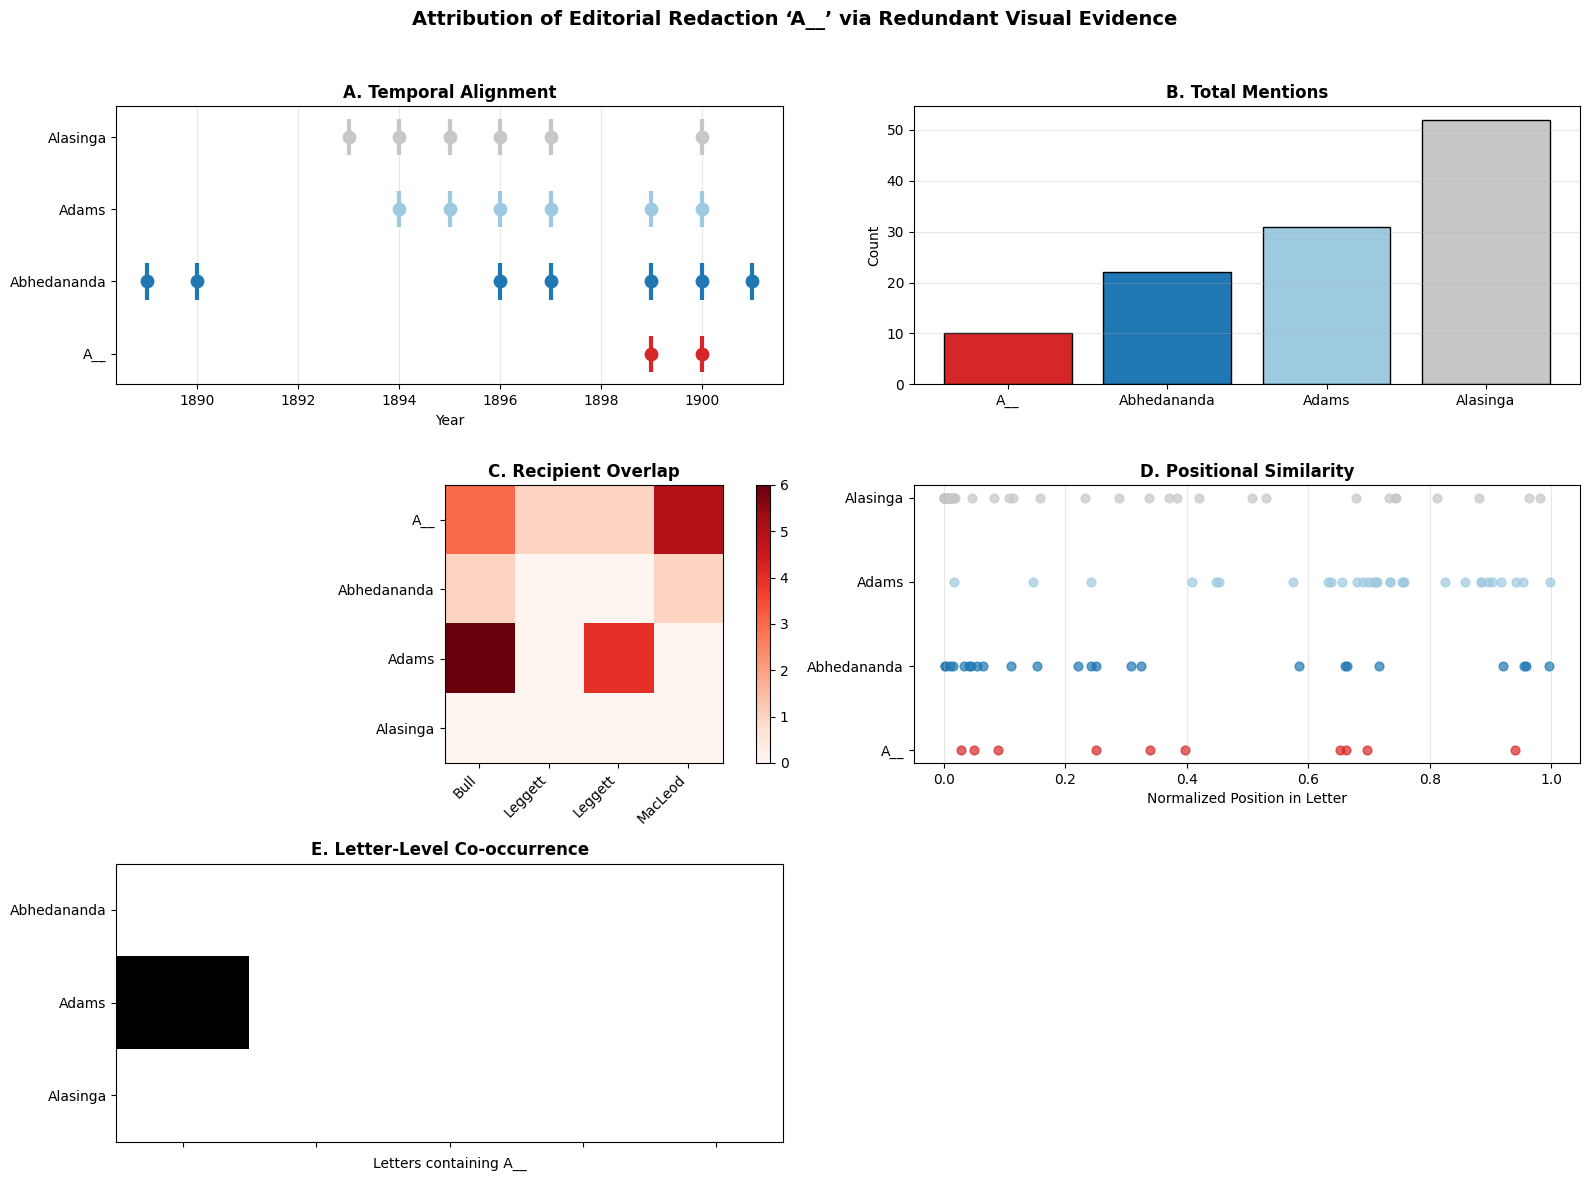

In [27]:
# =============================================================================
# FINAL ATTRIBUTION FIGURE — A__ REDACTION (REAL NAMES)
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# Labels (NO encoding)
# -----------------------------
labels = ['A__', 'Abhedananda', 'Adams', 'Alasinga']

# Colors
COL = {
    'A__': '#d62728',
    'Abhedananda': '#1f77b4',
    'Adams': '#9ecae1',
    'Alasinga': '#c7c7c7'
}

# -----------------------------
# Prepare data
# -----------------------------
year_data = {
    'A__': sorted(redaction_year_counts),
    'Abhedananda': sorted(candidate_stats['Abhedananda']['yearly_counts']),
    'Adams': sorted(candidate_stats['Adams']['yearly_counts']),
    'Alasinga': sorted(candidate_stats['Alasinga']['yearly_counts'])
}

freq_data = {
    'A__': redaction_year_counts,
    'Abhedananda': candidate_stats['Abhedananda']['yearly_counts'],
    'Adams': candidate_stats['Adams']['yearly_counts'],
    'Alasinga': candidate_stats['Alasinga']['yearly_counts']
}

# -----------------------------
# FIX: normalize recipient names (removes duplicates like "Leggett")
# -----------------------------
def normalize_name(s):
    return ' '.join(str(s).strip().split())

# Normalize redaction recipients
normalized_redaction_df = redaction_df.copy()
normalized_redaction_df['recipient_norm'] = normalized_redaction_df['recipient'].apply(normalize_name)

# Recompute normalized recipient counts
redaction_recipient_counts_norm = (
    normalized_redaction_df
    .groupby('recipient_norm')
    .size()
    .to_dict()
)

recipients = sorted(redaction_recipient_counts_norm.keys())

# Build heatmap using normalized recipients
heatmap = []
heatmap.append([redaction_recipient_counts_norm.get(r, 0) for r in recipients])

for name in labels[1:]:
    cand_counts = {
        normalize_name(k): v
        for k, v in candidate_stats[name]['recipient_counts'].items()
    }
    heatmap.append([cand_counts.get(r, 0) for r in recipients])

heatmap = np.array(heatmap)


positions = {
    'A__': redaction_positions,
    'Abhedananda': candidate_stats['Abhedananda']['positions'],
    'Adams': candidate_stats['Adams']['positions'],
    'Alasinga': candidate_stats['Alasinga']['positions']
}

letters = sorted(set(redaction_df['doc_id']))
co_matrix = []
for name in labels[1:]:
    cand_docs = set(candidate_df[candidate_df['candidate'] == name]['doc_id'])
    co_matrix.append([int(d in cand_docs) for d in letters])
co_matrix = np.array(co_matrix)

# -----------------------------
# Plot
# -----------------------------
fig = plt.figure(figsize=(16, 12))

# =============================
# PANEL A — TEMPORAL ALIGNMENT
# =============================
ax1 = plt.subplot(3, 2, 1)
ypos = np.arange(len(labels))

for i, lab in enumerate(labels):
    years = year_data[lab]
    ax1.vlines(years, i-0.25, i+0.25, color=COL[lab], linewidth=3)
    ax1.scatter(years, [i]*len(years), color=COL[lab], s=80)

ax1.set_yticks(ypos)
ax1.set_yticklabels(labels)
ax1.set_xlabel("Year")
ax1.set_title("A. Temporal Alignment", fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# =============================
# PANEL B — TOTAL MENTIONS
# =============================
ax2 = plt.subplot(3, 2, 2)

totals = [sum(freq_data[l].values()) for l in labels]
ax2.bar(labels, totals, color=[COL[l] for l in labels], edgecolor='black')

ax2.set_title("B. Total Mentions", fontweight='bold')
ax2.set_ylabel("Count")
ax2.grid(axis='y', alpha=0.3)

# =============================
# PANEL C — RECIPIENT OVERLAP
# =============================
ax3 = plt.subplot(3, 2, 3)

im = ax3.imshow(heatmap, cmap='Reds')
ax3.set_yticks(range(len(labels)))
ax3.set_yticklabels(labels)
ax3.set_xticks(range(len(recipients)))
ax3.set_xticklabels([r.split(',')[0][:10] for r in recipients],
                     rotation=45, ha='right')
ax3.set_title("C. Recipient Overlap", fontweight='bold')
plt.colorbar(im, ax=ax3, fraction=0.04)

# =============================
# PANEL D — POSITIONAL SIMILARITY
# =============================
ax4 = plt.subplot(3, 2, 4)

for i, lab in enumerate(labels):
    x = positions[lab]
    y = np.full(len(x), i)
    ax4.scatter(x, y, color=COL[lab], alpha=0.7, s=40)

ax4.set_yticks(range(len(labels)))
ax4.set_yticklabels(labels)
ax4.set_xlabel("Normalized Position in Letter")
ax4.set_title("D. Positional Similarity", fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# =============================
# PANEL E — LETTER CO-OCCURRENCE
# =============================
ax5 = plt.subplot(3, 2, 5)

im2 = ax5.imshow(co_matrix, aspect='auto', cmap='Greys')
ax5.set_yticks(range(len(labels)-1))
ax5.set_yticklabels(labels[1:])
ax5.set_xticks(range(len(letters)))
ax5.set_xticklabels([''] * len(letters))
ax5.set_xlabel("Letters containing A__")
ax5.set_title("E. Letter-Level Co-occurrence", fontweight='bold')

# =============================
# FINISH
# =============================
plt.suptitle(
    "Attribution of Editorial Redaction ‘A__’ via Redundant Visual Evidence",
    fontsize=14, fontweight='bold'
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [28]:
import pandas as pd
import re

print("=" * 80)
print("DIAGNOSTIC: RECIPIENT STRINGS CONTAINING 'LEGGETT'")
print("=" * 80)

# 1. Find all unique Audience values containing 'Leggett'
aud = df_clean['Audience'].dropna().astype(str)

leggett_variants = aud[aud.str.contains(r'Leggett', case=False, regex=True)]

print(f"\nTotal rows mentioning 'Leggett': {len(leggett_variants)}")
print(f"Unique Audience strings containing 'Leggett': {leggett_variants.nunique()}\n")

print("UNIQUE RAW AUDIENCE STRINGS:")
print("-" * 80)
for v in sorted(leggett_variants.unique()):
    print(repr(v))

# 2. Show invisible differences (whitespace / unicode)
print("\nWHITESPACE & LENGTH DIAGNOSTICS:")
print("-" * 80)
for v in sorted(leggett_variants.unique()):
    print({
        "string": repr(v),
        "length": len(v),
        "codepoints": [hex(ord(c)) for c in v]
    })

# 3. Check how many times each variant appears
print("\nFREQUENCY OF EACH VARIANT:")
print("-" * 80)
print(leggett_variants.value_counts())

# 4. Cross-check where they appear in the redaction heatmap source
print("\nAPPEARANCE IN REDACTION DATAFRAME:")
print("-" * 80)
if 'recipient' in redaction_df.columns:
    rd_leggett = redaction_df[redaction_df['recipient'].str.contains('Leggett', case=False, na=False)]
    print(rd_leggett['recipient'].value_counts())
else:
    print("redaction_df has no 'recipient' column")

print("\nDONE.")


DIAGNOSTIC: RECIPIENT STRINGS CONTAINING 'LEGGETT'

Total rows mentioning 'Leggett': 18
Unique Audience strings containing 'Leggett': 2

UNIQUE RAW AUDIENCE STRINGS:
--------------------------------------------------------------------------------
'Leggett, Francis H'
'Leggett, Francis Mrs.'

WHITESPACE & LENGTH DIAGNOSTICS:
--------------------------------------------------------------------------------
{'string': "'Leggett, Francis H'", 'length': 18, 'codepoints': ['0x4c', '0x65', '0x67', '0x67', '0x65', '0x74', '0x74', '0x2c', '0x20', '0x46', '0x72', '0x61', '0x6e', '0x63', '0x69', '0x73', '0x20', '0x48']}
{'string': "'Leggett, Francis Mrs.'", 'length': 21, 'codepoints': ['0x4c', '0x65', '0x67', '0x67', '0x65', '0x74', '0x74', '0x2c', '0x20', '0x46', '0x72', '0x61', '0x6e', '0x63', '0x69', '0x73', '0x20', '0x4d', '0x72', '0x73', '0x2e']}

FREQUENCY OF EACH VARIANT:
--------------------------------------------------------------------------------
Audience
Leggett, Francis H       9
Leg

In [26]:
import pandas as pd
import re

# Ensure Audience is string and non-null
aud = df_clean['Audience'].dropna().astype(str)

# Keep rows where either last name or first name starts with 'A'
mask = aud.apply(
    lambda x: any(
        part.strip().startswith(('A', 'a'))
        for part in re.split(r'[,\s]+', x)
        if part.strip()
    )
)

names_starting_with_A = aud[mask].sort_values().unique()

# Display results
print(f"Audience names where ANY name starts with 'A' (total: {len(names_starting_with_A)}):\n")
for name in names_starting_with_A:
    print(name)


Audience names where ANY name starts with 'A' (total: 13):

Abhedananda, Swami
Akhandananda, Swami
American Lady
Friend, American
Ghosh, Atul Chandra
Hansbrough, Alice (Shanti)
Hume, R. A. Rev.
Maharaja of Khetri (Singh, Ajit)
Perumal, Alasinga
Perumal, Alasinga 
Perumal, Alasinga; Balaji; Banking Corporation; Madras Friends
Sturges, Alberta
Sturges, Alberta (?)


In [34]:
import pandas as pd

# ============================================================
# CONFIG: audience + year pairs to inspect
# ============================================================
# Edit / extend this list as needed
TARGETS = [
    ("Nivedita, Sister", 1898),
    ("Light, Letter to Editor", 1896),
    ("Indian Mirror", 1896),
    ("Hale, Mary", 1896),
    ("Desai, Viaharidas Haridas", 1893),
    ("Leggett, Francis Mrs.", 1900),
]

# Column names (adjust ONLY if different in your CSV)
AUD_COL = "Audience"
DATE_COL = "Date"
TITLE_COL = "Name" if "Name" in df.columns else "Letter_Name"
URL_COL = "full_url" if "full_url" in df.columns else None

# Ensure Date is datetime
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df["year"] = df[DATE_COL].dt.year

print("=" * 90)
print("LETTER COUNTS BY AUDIENCE AND YEAR")
print("=" * 90)

for audience, year in TARGETS:
    subset = df[(df[AUD_COL] == audience) & (df["year"] == year)]

    print("\n" + "-" * 90)
    print(f"Audience : {audience}")
    print(f"Year     : {year}")
    print(f"Total letters: {len(subset)}")

    # If very small set, show details
    if len(subset) <= 5 and len(subset) > 0:
        print("\nDetails (≤ 5 letters):")
        for _, row in subset.iterrows():
            title = row[TITLE_COL] if TITLE_COL in row else "Unknown title"
            url = row[URL_COL] if URL_COL and URL_COL in row else "No URL available"
            print(f"  • {title}")
            print(f"    {url}")

    elif len(subset) == 0:
        print("  (No letters found)")

print("\nDONE.")


LETTER COUNTS BY AUDIENCE AND YEAR

------------------------------------------------------------------------------------------
Audience : Nivedita, Sister
Year     : 1898
Total letters: 4

Details (≤ 5 letters):
  • CXLI Margot
    https://www.ramakrishnavivekananda.info/vivekananda/volume_6/epistles_second_series/141_margot.htm
  • CXLIII Margot
    https://www.ramakrishnavivekananda.info/vivekananda/volume_6/epistles_second_series/143_margot.htm
  • CXVII Miss Noble
    https://www.ramakrishnavivekananda.info/vivekananda/volume_9/letters_fifth_series/117_miss_noble.htm
  • CXIX Margaret
    https://www.ramakrishnavivekananda.info/vivekananda/volume_9/letters_fifth_series/119_margaret.htm

------------------------------------------------------------------------------------------
Audience : Light, Letter to Editor
Year     : 1896
Total letters: 1

Details (≤ 5 letters):
  • XCVI Sir
    https://www.ramakrishnavivekananda.info/vivekananda/volume_9/letters_fifth_series/096_sir.htm

-----

In [33]:
import pandas as pd

AUDIENCE = "Husain, Mohammed Sarfaraz"
YEAR = 1898

# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["year"] = df["Date"].dt.year

subset = df[(df["Audience"] == AUDIENCE) & (df["year"] == YEAR)]

print("=" * 90)
print("LETTER CHECK")
print("=" * 90)
print(f"Audience : {AUDIENCE}")
print(f"Year     : {YEAR}")
print(f"Total letters: {len(subset)}")

if len(subset) <= 5 and len(subset) > 0:
    print("\nDetails (≤ 5 letters):")
    for _, row in subset.iterrows():
        title = row["Name"] if "Name" in df.columns else row.get("Letter_Name", "Unknown title")
        url = row["url_full"] if "url_full" in df.columns else "No URL available"
        print(f"  • {title}")
        print(f"    {url}")
elif len(subset) == 0:
    print("\n(No letters found)")

print("\nDONE.")


LETTER CHECK
Audience : Husain, Mohammed Sarfaraz
Year     : 1898
Total letters: 1

Details (≤ 5 letters):
  • CXLII Friend
    No URL available

DONE.


In [36]:
import pandas as pd

AUDIENCE = "Hume, R. A. Rev."
YEAR = 1894

# Ensure Date is parsed
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["year"] = df["Date"].dt.year

subset = df[(df["Audience"] == AUDIENCE) & (df["year"] == YEAR)]

print("=" * 90)
print("LETTER CHECK")
print("=" * 90)
print(f"Audience : {AUDIENCE}")
print(f"Year     : {YEAR}")
print(f"Total letters: {len(subset)}")

if len(subset) <= 5 and len(subset) > 0:
    print("\nDetails (≤ 5 letters):")
    for _, row in subset.iterrows():
        title = (
            row["Letter"]
            if "Letter" in df.columns
            else row.get("Name", "Unknown title")
        )
        url = row["full_url"] if "full_url" in df.columns else "No URL available"

        print(f"  • {title}")
        print(f"    {url}")

elif len(subset) == 0:
    print("\n(No letters found)")

print("\nDONE.")


LETTER CHECK
Audience : Hume, R. A. Rev.
Year     : 1894
Total letters: 1

Details (≤ 5 letters):
  • XV Brother
    https://www.ramakrishnavivekananda.info/vivekananda/volume_7/epistles_third_series/15_brother.htm

DONE.
